# Parameter guide for fingerprinting
The user uploads their data and sets the target attribute.

Our process gives insights of:
- feature importance for the specified target
- robustness of a fingerprint per se (extraction rate)
- utility loss by change in mean and variance (todo: add more parameters)
- utility loss by loss in performance on ML classifiers 
- robustness against classical attacks 
for different gamma values 

In [1]:
import os
os.chdir("C:\\Users\\tsarcevic\\PycharmProjects\\fingerprinting-toolbox")

In [2]:
import pickle

## 0. Upload the data 

In [3]:
data_path = "C:/Users/tsarcevic/PycharmProjects/fingerprinting-toolbox/datasets/adult_full.csv"
target = ['income']

In [4]:
from parameter_guidelines.guidelines import *

In [5]:
# todo: get_full_insights <- this fingerprints the 100 datasets and compresses them later together with metadata

In [6]:
#get_insights(data=data_path, target=target, primary_key_attribute=primary_key)

## 1. Robustness

In [5]:
data = pd.read_csv('datasets/adult.csv', na_values='?')
# # to focus on real stuff, let's ignore missing values
data = data.dropna()

#data = Adult().preprocessed()

In [6]:
xi = 1
fplen = 32
numbuyers = 100
gammae = [1,2,3,4,5,6,10,12,15,18,20,25,30,50,100,200] # 35 40 50 60 70 80

In [7]:
# -------------------------------------------------#
            # ROBUSTNESS EVALUATION #
# ------------------------------------------------ #
def robustness_evaluation(attack, data, attack_string, gammae, attack_granularity=0.05, n_experiments=100, confidence_rate=0.9, 
                          target=None):
    try:
        target = data.get_target_attribute()
    except AttributeError:
        pass
    
    xi = 1
    fplen = 32
    numbuyers = 100
    
    if attack_string == 'vertical':
        file_string = 'robustness_{}_universal_c{}_e{}.pickle'.format(attack_string,
                                                                                format(confidence_rate,".2f")[-2:], 
                                                                                n_experiments)
    else:
        file_string = 'robustness_{}_universal_c{}_ag{}_e{}.pickle'.format(attack_string,
                                                                                    format(confidence_rate,".2f")[-2:], 
                                                                                    format(attack_granularity,".2f")[-2:], 
                                                                                    n_experiments)
    # check if results exist
    # ---------------------- #
    if os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
        with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
            resutls = pickle.load(infile)
    else:
        resutls = {}
    gammae_new = []
    for gamma in gammae:
        if gamma not in resutls.keys():
            gammae_new.append(gamma)
            print('Updating results with gamma={}'.format(gamma))
    # ---------------------- #

    for gamma in gammae_new:
        scheme = Universal(gamma=gamma, 
                            xi=xi, 
                            fingerprint_bit_length=fplen, 
                            number_of_recipients=numbuyers)
        # from how much remaining data can the fingerprint still be extracted?
        remaining = robustness(attack, scheme, exclude=[target], 
                                       attack_granularity=attack_granularity,
                                      n_experiments=n_experiments, 
                                      confidence_rate=confidence_rate)
        resutls[gamma] = remaining
    resutls =  dict(sorted(resutls.items()))
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(resutls, outfile)

In [8]:
def robustness_statistical(attack, data, attack_string, gammae, attack_granularity=0.05, confidence_rate=0.9):
    file_string = 'robustness_stat_{}_universal_c{}_ag{}.pickle'.format(attack_string, 
                                                                       format(confidence_rate,".2f")[-2:],
                                                                       format(attack_granularity,".2f")[-2:])
    # check if results exist
    # ---------------------- #
    if os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
        with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
            resutls = pickle.load(infile)
    else:
        resutls = {}
    gammae_new = []
    for gamma in gammae:
        if gamma not in resutls.keys():
            gammae_new.append(gamma)
            print('Updating results with gamma={}'.format(gamma))
    # ---------------------- #
    
    xi = 1
    fplen = 32
    numbuyers = 100
    
    result = dict()
    for gamma in gammae:
        scheme = Universal(gamma=gamma, 
                            xi=xi, 
                            fingerprint_bit_length=fplen, 
                            number_of_recipients=numbuyers)
        # find a strenght for which the attack success drops below 10%
        attack_strength = attack_granularity
        # if i flip 5% of data, what is the probability of attack success
        fm = attack.false_miss_estimation(data, attack_strength, scheme) 
        # is it less than 10%? let's increase the strength to see if this was the boundary
        while(fm < 1-confidence_rate):
            attack_strength += attack_granularity
        # if i flip 5% of data, what is the probability of attack success
            fm = attack.false_miss_estimation(data, attack_strength, scheme) 
        # is it more than 10%? then the previous strength was the robustness
        robustness = attack_strength - attack_granularity
        result[gamma] = round(robustness,2)
    result =  dict(sorted(result.items()))
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(result, outfile)
    return result

### 1.1. Horizontal subset attack

In [10]:
attack = HorizontalSubsetAttack()

In [11]:
robustness_evaluation(attack, data, 'horizontal', [1,2,3,6,10,50], confidence_rate=0.70, n_experiments=2, target='income')

<IPython.core.display.Javascript object>


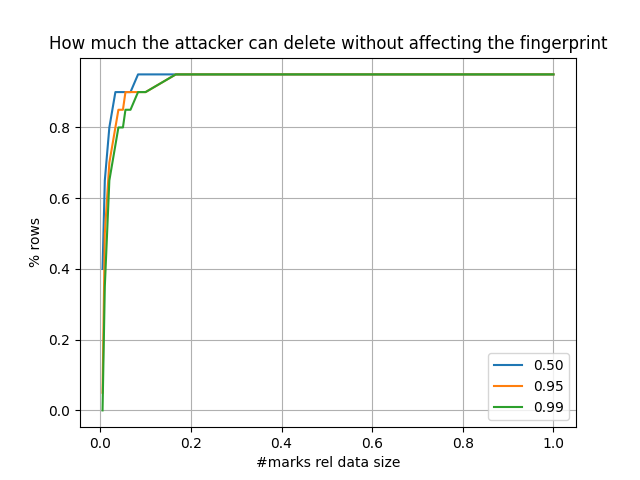

In [13]:
%matplotlib notebook
confidence_rates = [0.50, 0.95, 0.99]
attack_granularity = 0.05
n_experiments = 100
for confidence_rate in confidence_rates:
    file_string = 'inverse_robustness_horizontal_universal_c{}_ag{}_e{}.pickle'.format(format(confidence_rate,".2f")[-2:], 
                                                                                       format(attack_granularity,".2f")[-2:], 
                                                                                       n_experiments)
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        resutls = pickle.load(infile)
    plt.plot([1.0/g for g in resutls.keys()], [1 - inv_robustness for inv_robustness in resutls.values()], 
             label= str(format(confidence_rate,".2f")))
plt.title('How much the attacker can delete without affecting the fingerprint')
plt.xlabel('#marks rel data size') 
plt.ylabel('% rows')
plt.legend()
plt.grid()

In [19]:
robustness_statistical(attack, data, 'horizontal', gammae=[1,2,3,4,5,6,10,12,15,18,20,25,30,35,40,50,60,70,80,100,200],
                      attack_granularity=0.05, confidence_rate=0.99)

Updating results with gamma=1
Updating results with gamma=2
Updating results with gamma=3
Updating results with gamma=4
Updating results with gamma=5
Updating results with gamma=6
Updating results with gamma=10
Updating results with gamma=12
Updating results with gamma=15
Updating results with gamma=18
Updating results with gamma=20
Updating results with gamma=25
Updating results with gamma=30
Updating results with gamma=35
Updating results with gamma=40
Updating results with gamma=50
Updating results with gamma=60
Updating results with gamma=70
Updating results with gamma=80
Updating results with gamma=100
Updating results with gamma=200


{1: 0.95,
 2: 0.95,
 3: 0.95,
 4: 0.95,
 5: 0.95,
 6: 0.95,
 10: 0.9,
 12: 0.9,
 15: 0.9,
 18: 0.9,
 20: 0.85,
 25: 0.85,
 30: 0.8,
 35: 0.8,
 40: 0.75,
 50: 0.75,
 60: 0.7,
 70: 0.65,
 80: 0.6,
 100: 0.55,
 200: 0.3}

<IPython.core.display.Javascript object>


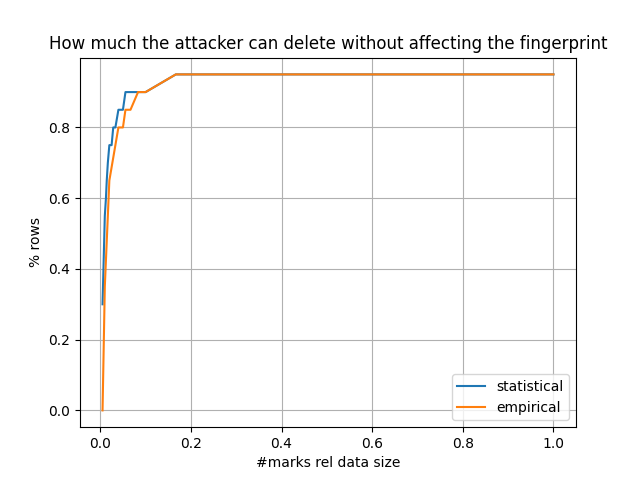

In [21]:
%matplotlib notebook
confidence_rates = [0.99]
attack_granularity= 0.05
for confidence_rate in confidence_rates:
    file_string = 'robustness_stat_horizontal_universal_c{}_ag{}.pickle'.format(format(confidence_rate,".2f")[-2:], 
                                                                             format(attack_granularity, ".2f")[-2:])
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        resutls = pickle.load(infile)
    plt.plot([1.0/g for g in resutls.keys()], [robustness for robustness in resutls.values()], 
             label= 'statistical')
    #------------------------#
    file_string = 'inverse_robustness_horizontal_universal_c{}_ag{}_e{}.pickle'.format(format(confidence_rate,".2f")[-2:], 
                                                                                       format(attack_granularity,".2f")[-2:], 
                                                                                       n_experiments)
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        resutls = pickle.load(infile)
    plt.plot([1.0/g for g in resutls.keys()], [1 - inv_robustness for inv_robustness in resutls.values()], 
             label= 'empirical')
plt.title('How much the attacker can delete without affecting the fingerprint')
plt.xlabel('#marks rel data size') 
plt.ylabel('% rows')
plt.legend()
plt.grid()

### 1.2. Vertical subset attack

In [22]:
attack = VerticalSubsetAttack()

In [ ]:
robustness_evaluation(attack, data, 'vertical', gammae=[1,2,3,6,12,20,50,100], 
                      confidence_rate=0.95, target='income', n_experiments=100) 

Updating results with gamma=1
Updating results with gamma=2
Updating results with gamma=3
Updating results with gamma=6
Updating results with gamma=12
Updating results with gamma=20
Updating results with gamma=50
Updating results with gamma=100
['native-country', 'occupation', 'hours-per-week', 'age', 'education-num', 'race', 'relationship', 'education', 'fnlwgt', 'capital-loss', 'marital-status', 'sex', 'capital-gain']
Vertical subset attack runtime on 13 out of 14 columns: 0.0010018348693847656 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11001101010111101120101001011010
Counts:
[[625, 735],
 [737, 741],
 [770, 674],
 [780, 637],
 [679, 747],
 [625, 771],
 [729

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01001010001011100011100011111001
Counts:
[[744, 689],
 [622, 686],
 [723, 623],
 [764, 666],
 [645, 793],
 [758, 693],
 [661, 749],
 [743, 690],
 [744, 695],
 [735, 654],
 [657, 709],
 [745, 675],
 [683, 741],
 [647, 758],
 [677, 755],
 [759, 687],
 [743, 623],
 [757, 639],
 [704, 793],
 [694, 775],
 [686, 738],
 [750, 699],
 [731, 584],
 [753, 672],
 [654, 745],
 [655, 760],
 [672, 775],
 [654, 759],
 [629, 768],
 [722, 669],
 [720, 692],
 [692, 745]]
Recipient 1 is suspected.
Runtime: 4 sec.
['education', 'marital-status', 'occupation', 'fnlwgt', 'native-country', 'age', 'workclass', 'relationship', 'capital-loss', 'education-num', 'hours-per-week', 'sex', 'race']
Vertical subset att

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11011000010010100111011110100111
Counts:
[[639, 760],
 [681, 731],
 [750, 676],
 [650, 785],
 [663, 775],
 [757, 677],
 [773, 608],
 [739, 658],
 [771, 603],
 [648, 755],
 [758, 685],
 [744, 659],
 [640, 755],
 [751, 685],
 [680, 775],
 [770, 676],
 [778, 668],
 [682, 746],
 [624, 743],
 [660, 699],
 [777, 658],
 [678, 770],
 [715, 775],
 [717, 745],
 [673, 778],
 [797, 618],
 [598, 774],
 [716, 633],
 [726, 673],
 [621, 725],
 [682, 757],
 [587, 752]]
Recipient 1 is suspected.
Runtime: 4 sec.
['marital-status', 'relationship', 'hours-per-week', 'education-num', 'occupation', 'education', 'capital-loss', 'age', 'race', 'fnlwgt', 'workclass', 'capital-gain', 'sex']
Vertical subset attac

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00001010110001000111111111110101
Counts:
[[718, 638],
 [783, 661],
 [729, 699],
 [772, 640],
 [626, 741],
 [787, 649],
 [597, 784],
 [741, 668],
 [694, 741],
 [645, 813],
 [745, 677],
 [744, 664],
 [746, 657],
 [664, 797],
 [736, 679],
 [777, 652],
 [739, 694],
 [646, 743],
 [643, 740],
 [666, 752],
 [656, 749],
 [670, 755],
 [619, 713],
 [630, 743],
 [680, 745],
 [631, 789],
 [653, 731],
 [640, 735],
 [774, 642],
 [697, 800],
 [750, 711],
 [664, 758]]
Recipient 1 is suspected.
Runtime: 4 sec.
['capital-loss', 'occupation', 'sex', 'fnlwgt', 'education', 'capital-gain', 'native-country', 'workclass', 'marital-status', 'age', 'hours-per-week', 'race', 'relationship']
Vertical subset atta

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00010010010001110001100011101110
Counts:
[[743, 661],
 [780, 687],
 [748, 619],
 [661, 734],
 [777, 689],
 [732, 663],
 [725, 775],
 [744, 656],
 [795, 660],
 [652, 756],
 [741, 648],
 [745, 670],
 [694, 655],
 [647, 765],
 [660, 737],
 [636, 770],
 [770, 619],
 [709, 668],
 [766, 602],
 [648, 781],
 [624, 745],
 [741, 669],
 [775, 645],
 [784, 657],
 [613, 813],
 [675, 763],
 [644, 775],
 [790, 618],
 [663, 767],
 [633, 796],
 [654, 788],
 [759, 643]]
Recipient 1 is suspected.
Runtime: 4 sec.
['workclass', 'education', 'fnlwgt', 'education-num', 'hours-per-week', 'relationship', 'age', 'marital-status', 'race', 'occupation', 'capital-loss', 'sex', 'native-country']
Vertical subset att

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10100010110110011000101110010100
Counts:
[[715, 763],
 [749, 674],
 [701, 772],
 [756, 658],
 [713, 694],
 [751, 647],
 [624, 748],
 [717, 656],
 [626, 772],
 [641, 778],
 [755, 653],
 [635, 789],
 [651, 751],
 [787, 694],
 [764, 690],
 [705, 778],
 [643, 740],
 [757, 598],
 [727, 677],
 [701, 652],
 [659, 800],
 [728, 633],
 [658, 713],
 [654, 765],
 [634, 788],
 [732, 639],
 [778, 657],
 [690, 756],
 [730, 648],
 [659, 745],
 [777, 660],
 [770, 647]]
Recipient 1 is suspected.
Runtime: 4 sec.
['relationship', 'sex', 'race', 'age', 'education', 'education-num', 'hours-per-week', 'workclass', 'fnlwgt', 'marital-status', 'native-country', 'capital-gain', 'capital-loss']
Vertical subset a

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11111101101000010110100001100100
Counts:
[[657, 802],
 [679, 751],
 [666, 747],
 [663, 770],
 [648, 774],
 [627, 737],
 [757, 665],
 [654, 831],
 [634, 787],
 [811, 676],
 [627, 742],
 [812, 662],
 [732, 659],
 [722, 613],
 [784, 657],
 [680, 773],
 [730, 679],
 [652, 763],
 [637, 711],
 [757, 663],
 [649, 750],
 [724, 708],
 [761, 665],
 [708, 687],
 [697, 637],
 [664, 751],
 [653, 739],
 [765, 641],
 [727, 669],
 [609, 788],
 [782, 713],
 [709, 635]]
No one suspected.
Runtime: 4 sec.
['race', 'marital-status', 'fnlwgt', 'native-country', 'capital-gain', 'education-num', 'education', 'hours-per-week', 'relationship', 'workclass', 'sex', 'capital-loss', 'age']
Vertical subset attack ru

Potential fingerprint detected: 00111010110000101110000110001001
Counts:
[[825, 605],
 [829, 647],
 [598, 841],
 [590, 754],
 [611, 827],
 [887, 562],
 [664, 766],
 [833, 636],
 [599, 803],
 [591, 824],
 [863, 627],
 [782, 660],
 [796, 561],
 [770, 657],
 [586, 780],
 [828, 616],
 [628, 790],
 [592, 823],
 [602, 770],
 [804, 597],
 [818, 533],
 [796, 581],
 [838, 581],
 [607, 836],
 [616, 847],
 [788, 590],
 [830, 584],
 [808, 605],
 [606, 826],
 [800, 598],
 [789, 564],
 [576, 781]]
Recipient 1 is suspected.
Runtime: 4 sec.
['education', 'education-num', 'workclass', 'occupation', 'relationship', 'fnlwgt', 'capital-loss', 'age', 'capital-gain', 'native-country', 'race', 'marital-status']
Vertical subset attack runtime on 12 out of 14 columns: 0.002000093460083008 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationshi

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01000001110101100110100001100111
Counts:
[[779, 658],
 [596, 803],
 [779, 592],
 [800, 595],
 [803, 651],
 [817, 550],
 [781, 637],
 [643, 795],
 [559, 797],
 [628, 824],
 [776, 603],
 [566, 818],
 [797, 628],
 [632, 820],
 [636, 792],
 [822, 631],
 [801, 596],
 [659, 787],
 [614, 812],
 [829, 599],
 [674, 821],
 [794, 594],
 [816, 623],
 [829, 595],
 [778, 571],
 [590, 787],
 [601, 790],
 [818, 588],
 [821, 588],
 [615, 800],
 [624, 769],
 [597, 834]]
Recipient 1 is suspected.
Runtime: 4 sec.
['relationship', 'education-num', 'capital-gain', 'race', 'marital-status', 'fnlwgt', 'occupation', 'age', 'capital-loss', 'education', 'sex', 'hours-per-week']
Vertical subset attack runtime on 

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01011101110010011001001000010011
Counts:
[[771, 636],
 [618, 811],
 [822, 544],
 [645, 818],
 [650, 790],
 [581, 802],
 [797, 618],
 [633, 789],
 [605, 871],
 [621, 800],
 [847, 541],
 [841, 653],
 [603, 841],
 [744, 588],
 [788, 628],
 [586, 786],
 [552, 820],
 [824, 606],
 [823, 637],
 [603, 794],
 [751, 622],
 [802, 608],
 [571, 815],
 [820, 625],
 [803, 610],
 [821, 580],
 [849, 637],
 [544, 827],
 [816, 619],
 [816, 580],
 [551, 786],
 [640, 802]]
Recipient 1 is suspected.
Runtime: 4 sec.
['capital-loss', 'capital-gain', 'fnlwgt', 'education-num', 'workclass', 'marital-status', 'native-country', 'age', 'education', 'race', 'occupation', 'hours-per-week']
Vertical subset attack run

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 10011000000011010101000001110000
Counts:
[[603, 815],
 [818, 619],
 [796, 628],
 [613, 854],
 [558, 835],
 [823, 611],
 [821, 590],
 [869, 575],
 [755, 578],
 [809, 591],
 [809, 610],
 [802, 574],
 [614, 785],
 [582, 798],
 [808, 606],
 [667, 809],
 [782, 612],
 [577, 816],
 [814, 649],
 [571, 731],
 [827, 624],
 [802, 612],
 [862, 581],
 [788, 625],
 [821, 585],
 [563, 795],
 [620, 817],
 [573, 873],
 [796, 572],
 [840, 651],
 [769, 619],
 [779, 651]]
Recipient 1 is suspected.
Runtime: 4 sec.
['workclass', 'capital-loss', 'fnlwgt', 'race', 'sex', 'hours-per-week', 'education', 'native-country', 'marital-status', 'relationship', 'education-num', 'age']
Vertical subset attack runtime on

['race', 'marital-status', 'fnlwgt', 'hours-per-week', 'capital-loss', 'education-num', 'occupation', 'sex', 'native-country', 'age', 'relationship', 'education']
Vertical subset attack runtime on 12 out of 14 columns: 0.003987550735473633 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 00101010010111100111100111100101
Counts:
[[845, 637],
 [801, 579],
 [593, 826],
 [834, 609],
 [596, 790],
 [792, 627],
 [609, 773],
 [763, 588],
 [871, 586],
 [620, 825],
 [860, 625],
 [581, 820],
 [598, 708],
 [605, 773],
 [591, 805],
 [820, 602],
 [795, 649],
 [627, 779],
 [634, 795],
 [593, 803],
 [602, 798],
 [833, 605],
 [793, 650],
 [606, 709],
 [671, 798],
 [573, 871],
 [616, 

Potential fingerprint detected: 00111110111011001001110010001110
Counts:
[[830, 556],
 [769, 622],
 [611, 852],
 [591, 839],
 [617, 773],
 [630, 833],
 [587, 794],
 [789, 646],
 [615, 783],
 [614, 789],
 [601, 714],
 [765, 594],
 [633, 823],
 [586, 838],
 [785, 632],
 [775, 589],
 [586, 836],
 [841, 602],
 [810, 610],
 [627, 770],
 [613, 774],
 [607, 823],
 [781, 610],
 [804, 585],
 [611, 772],
 [773, 644],
 [840, 606],
 [845, 650],
 [625, 827],
 [565, 825],
 [613, 804],
 [842, 626]]
Recipient 1 is suspected.
Runtime: 4 sec.
['age', 'education-num', 'capital-loss', 'fnlwgt', 'relationship', 'marital-status', 'workclass', 'education', 'hours-per-week', 'occupation', 'native-country', 'capital-gain']
Vertical subset attack runtime on 12 out of 14 columns: 0.0019986629486083984 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', '

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11001111111101011100100010001011
Counts:
[[590, 837],
 [590, 819],
 [794, 628],
 [769, 587],
 [607, 761],
 [546, 817],
 [624, 794],
 [585, 815],
 [637, 776],
 [620, 824],
 [623, 764],
 [619, 810],
 [794, 612],
 [579, 793],
 [844, 620],
 [584, 825],
 [611, 848],
 [611, 791],
 [810, 607],
 [810, 603],
 [584, 828],
 [785, 659],
 [865, 591],
 [830, 658],
 [598, 793],
 [830, 583],
 [870, 558],
 [766, 611],
 [606, 812],
 [806, 596],
 [581, 848],
 [591, 795]]
Recipient 1 is suspected.
Runtime: 4 sec.
['education', 'race', 'hours-per-week', 'fnlwgt', 'native-country', 'sex', 'education-num', 'occupation', 'capital-loss', 'relationship', 'marital-status', 'capital-gain']
Vertical subset attack 

	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 01000101010011101111010111010010
Counts:
[[778, 615],
 [648, 853],
 [793, 607],
 [817, 607],
 [774, 594],
 [605, 760],
 [829, 611],
 [574, 816],
 [828, 595],
 [588, 826],
 [773, 597],
 [857, 558],
 [653, 805],
 [546, 821],
 [613, 852],
 [810, 608],
 [586, 758],
 [604, 836],
 [620, 807],
 [654, 836],
 [759, 581],
 [627, 815],
 [799, 613],
 [598, 837],
 [602, 822],
 [650, 834],
 [768, 577],
 [600, 816],
 [792, 614],
 [767, 592],
 [590, 819],
 [830, 608]]
Recipient 1 is suspected.
Runtime: 4 sec.
['education', 'workclass', 'capital-gain', 'relationship', 'age', 'fnlwgt', 'education-num', 'marital-status', 'sex', 'capital-loss', 'occupation', 'hours-per-week']
Vertical subset attack runtim

<IPython.core.display.Javascript object>


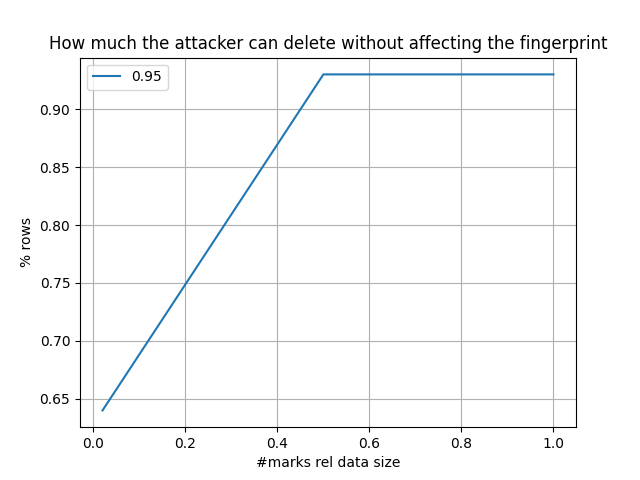

In [24]:
%matplotlib notebook
confidence_rates = [0.95]
n_experiments = 3
for confidence_rate in confidence_rates:
    file_string = 'robustness_vertical_universal_c{}_e{}.pickle'.format(format(confidence_rate,".2f")[-2:], 
                                                                                       n_experiments)
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        resutls = pickle.load(infile)
    plt.plot([1.0/g for g in resutls.keys()], [robustness for robustness in resutls.values()], 
             label= str(format(confidence_rate,".2f")))
plt.title('How much the attacker can delete without affecting the fingerprint')
plt.xlabel('#marks rel data size') 
plt.ylabel('% rows')
plt.legend()
plt.grid()

### 1.3. Flipping attack

In [52]:
attack = FlippingAttack()

In [10]:
#robustness_evaluation(attack, data, 'flipping', gammae=[1], confidence_rate=0.95, target='income', n_experiments=1, 
#                      attack_granularity=0.1)

In [55]:
robustness_statistical(attack, data, 'flipping', gammae=[1,2,3,4,5,6,10,12,15,18,20,25,30,35,40,50,60,70,80,100,200],
                      attack_granularity=0.02, confidence_rate=0.95)

Updating results with gamma=1
Updating results with gamma=2
Updating results with gamma=3
Updating results with gamma=4
Updating results with gamma=5
Updating results with gamma=6
Updating results with gamma=10
Updating results with gamma=12
Updating results with gamma=15
Updating results with gamma=18
Updating results with gamma=20
Updating results with gamma=25
Updating results with gamma=30
Updating results with gamma=35
Updating results with gamma=40
Updating results with gamma=50
Updating results with gamma=60
Updating results with gamma=70
Updating results with gamma=80
Updating results with gamma=100
Updating results with gamma=200


{1: 0.46,
 2: 0.44,
 3: 0.42,
 4: 0.4,
 5: 0.4,
 6: 0.4,
 10: 0.36,
 12: 0.34,
 15: 0.34,
 18: 0.32,
 20: 0.32,
 25: 0.3,
 30: 0.26,
 35: 0.26,
 40: 0.24,
 50: 0.22,
 60: 0.18,
 70: 0.18,
 80: 0.14,
 100: 0.14,
 200: 0.02}

<IPython.core.display.Javascript object>


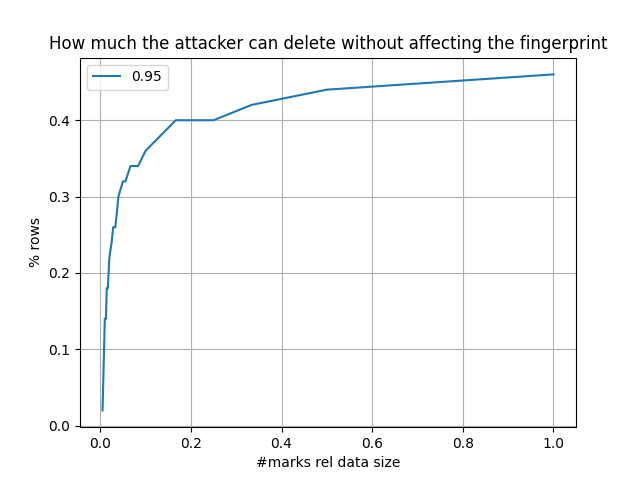

In [57]:
%matplotlib notebook
confidence_rates = [0.95]
attack_granularity= 0.02
for confidence_rate in confidence_rates:
    file_string = 'robustness_stat_flipping_universal_c{}_ag{}.pickle'.format(format(confidence_rate,".2f")[-2:], 
                                                                             format(attack_granularity, ".2f")[-2:])
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        resutls = pickle.load(infile)
    plt.plot([1.0/g for g in resutls.keys()], [robustness for robustness in resutls.values()], 
             label= str(format(confidence_rate,".2f")))
plt.title('How much the attacker can delete without affecting the fingerprint')
plt.xlabel('#marks rel data size') 
plt.ylabel('% rows')
plt.legend()
plt.grid()

In [12]:
resutls

{1: 0.9}

## 2. Attack utility decrease

In [15]:
results = {}
attack_granularity = 0.05
n_folds = 5
file_string = 'attack_utility_horizontal_universal_knn_{}_ag{}_nf{}.pickle'.format(target, 
                                                                               format(attack_granularity,".2f")[-2:], 
                                                                                   n_folds)
# check if results exist
# ---------------------- #
if not os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
    # returns estimated utility drop for each attack strength
    attack_utility_knn = attack_utility_knn(Adult().preprocessed(), target, attack, attack_granularity=attack_granularity, 
                                            n_folds=n_folds)


    with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(attack_utility_knn, outfile)
else:
    print('Results already exist. Not taking any action.')
# ---------------------- #

Results already exist. Not taking any action.


In [71]:
file_string = 'attack_utility_horizontal_universal_knn_{}_ag{}_nf{}.pickle'.format(target, 
                                                                               format(attack_granularity,".2f")[-2:], 
                                                                                   n_folds)
with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
    attack_utility_knn = pickle.load(infile)
attack_utility_knn = dict(sorted(attack_utility_knn.items()))

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


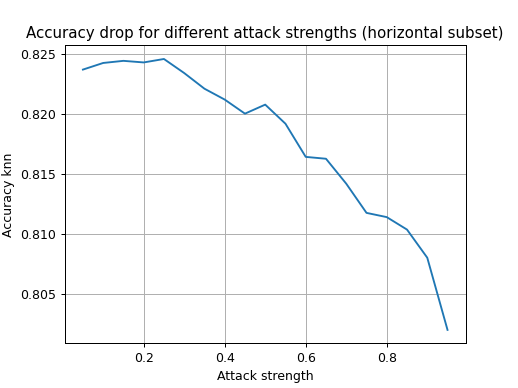

Text(0.5, 1.0, 'Accuracy drop for different attack strengths (horizontal subset)')

In [72]:
%matplotlib
plt.plot(attack_utility_knn.keys(), [np.mean(acc) for acc in attack_utility_knn.values()])
plt.xlabel('Attack strength')
plt.ylabel('Accuracy knn')
plt.title('Accuracy drop for different attack strengths (horizontal subset)')

In [18]:
# original accuracy
file_string = 'utility_knn_{}_nf{}.pickle'.format(target, n_folds)
if not os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
    # from how much remaining data can the fingerprint still be extracted?
    original_utility_knn = original_utility_knn(Adult().preprocessed(), target, n_folds=n_folds)

    with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(original_utility_knn, outfile)
else:
    print('Results already exist. Not taking any action.')

Results already exist. Not taking any action.


In [19]:
file_string = 'utility_knn_{}_nf{}.pickle'.format(target, n_folds)
with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
    original_utility_knn = pickle.load(infile)

In [20]:
#acceptable_utility_drop = 0.01
#utility_preserving_attack_strength = max([strength for strength in attack_utility_knn 
#                                         if np.mean(original_utility_knn)-np.mean(attack_utility_knn[strength])<=acceptable_utility_drop])
# alternative
# attacks that yield at least 1% of accuracy loss
#attacks_1p = max([strength for strength in attack_utility_knn 
#                  if np.mean(original_utility_knn)-np.mean(attack_utility_knn[strength])<=0.01])
# attacks that yield at least 2% of accuracy loss
#attacks_2p = max([strength for strength in attack_utility_knn 
#                                         if np.mean(original_utility_knn)-np.mean(attack_utility_knn[strength])<=0.02])
#
#attacks_3p = max([strength for strength in attack_utility_knn
#                 if np.mean(original_utility_knn)-np.mean(attack_utility_knn[strength])<=0.03])

In [21]:
#max_utility_drop = np.mean(original_utility_knn) - min(np.mean(acc) for acc in attack_utility_knn.values())

In [75]:
# retruns a list [attack_with_1%_loss, attack_with_2%_loss, ... , max_abs_utility_loss]
att_utility_bounds = attack_utility_bounds(original_utility_knn, attack_utility_knn) 

<IPython.core.display.Javascript object>


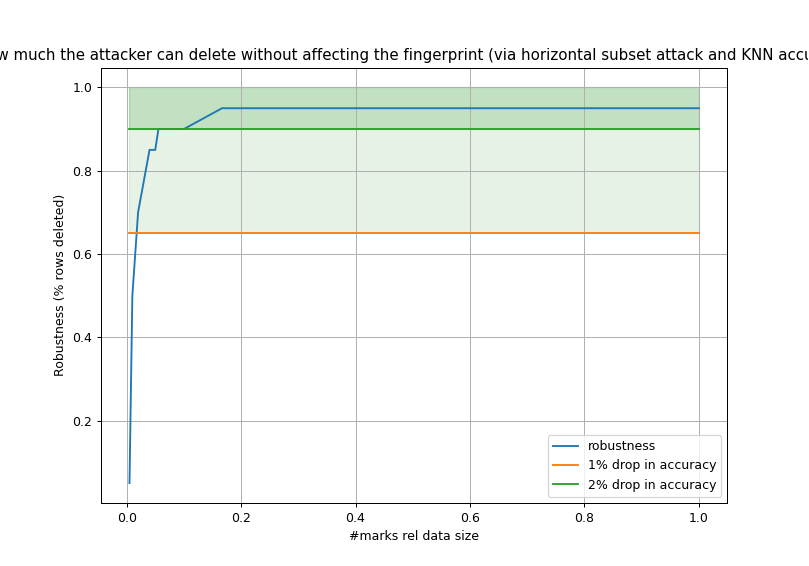

In [76]:
%matplotlib notebook
with open('parameter_guidelines/evaluation/adult/inverse_robustness_horizontal_universal_c95_ag05_e100.pickle', 'rb') as infile:
    resutls = pickle.load(infile)
fig, ax = plt.subplots(figsize=(10, 7))

lines = []
fill = []

lines.append(ax.plot([1.0/g for g in resutls.keys()], [1 - inv_robustness for inv_robustness in resutls.values()], label='robustness'))
lines.append(ax.plot([1.0/g for g in resutls.keys()], [att_utility_bounds[0] for x in resutls], label='1% drop in accuracy'))
fill.append(ax.fill_between([1.0/g for g in resutls.keys()], [att_utility_bounds[0] for x in resutls], 1.0, color='green', alpha=0.1))
lines.append(ax.plot([1.0/g for g in resutls.keys()], [att_utility_bounds[1] for x in resutls], label='2% drop in accuracy'))
fill.append(ax.fill_between([1.0/g for g in resutls.keys()], [att_utility_bounds[1] for x in resutls], 1.0, color='green', alpha=0.15))

plt.title('How much the attacker can delete without affecting the fingerprint (via horizontal subset attack and KNN accuracy)')
plt.xlabel('#marks rel data size') 
plt.ylabel('Robustness (% rows deleted)')

legend = plt.legend()
line_legends = legend.get_lines()
for line in line_legends:
    line.set_picker(True)
    line.set_pickradius(10)
graphs = {}
graphs[line_legends[0]] = [lines[0][0]]
graphs[line_legends[1]] = [lines[1][0], fill[0]]
graphs[line_legends[2]] = [lines[2][0], fill[1]]
   
def on_pick(event):
    legend = event.artist
    isVisible = legend.get_visible()
    for element in graphs[legend]:
        element.set_visible(not isVisible)
    legend.set_visible(not isVisible)
    fig.canvas.draw()
    
plt.connect('pick_event', on_pick)
plt.show()

## 3. Utility after fingerprinting

### 3.1. KNN 

In [86]:
#gammae = [1, 3, 6, 12, 25, 50, 100]
fp_utility_results = {}
n_folds = 5
n_experiments = 10

file_string = 'utility_universal_knn_{}_nf{}_e{}.pickle'.format(target, n_folds, n_experiments)

# check if results exist
# ---------------------- #
if os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
            fp_utility_results = pickle.load(infile)
gammae_new = []
for gamma in gammae:
    if gamma not in fp_utility_results.keys():
        gammae_new.append(gamma)
# ---------------------- #        
# update results
for gamma in gammae_new:
    fp_utility_knn = fingerprint_utility_knn(Adult(), target, gamma, n_folds=n_folds, n_experiments=n_experiments) 
    # [cv_acc_1, cv_acc_2, ..., cv_acc_n_exp]
    fp_utility_results[gamma] = fp_utility_knn
    
fp_utility_results =  dict(sorted(fp_utility_results.items()))
with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(fp_utility_results, outfile)

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


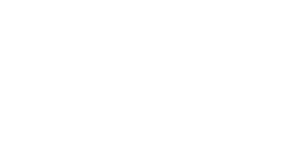

Text(0, 0.5, 'Accuracy knn')

In [87]:
%matplotlib
file_string = 'utility_universal_knn_{}_nf{}_e{}.pickle'.format(target, n_folds, n_experiments)
with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        fp_utility_results = pickle.load(infile)
        
x_axis = [1.0/g for g in fp_utility_results.keys()]
y_axis = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results[gamma]]) for gamma in fp_utility_results.keys()]
plt.plot(x_axis, y_axis, label='utility after fingerprint')
plt.title('Utility of fingerprinted data')
plt.xlabel('#marks rel data size')
plt.ylabel('Accuracy knn')

### 3.2. Decision Tree

In [88]:
#gammae = [1, 2, 3, 4, 6, 12, 25, 50, 100]
fp_utility_results_DT = {}
n_folds = 5
n_experiments = 10

file_string = 'utility_universal_dt_{}_nf{}_e{}.pickle'.format(target, n_folds, n_experiments)

# check if results exist
# ---------------------- #
if os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
            fp_utility_results_DT = pickle.load(infile)
    print('Results already exist for gammae: ' + str(fp_utility_results_DT.keys()))
gammae_new = []
for gamma in gammae:
    if gamma not in fp_utility_results_DT.keys():
        gammae_new.append(gamma)
# ---------------------- #        
# update results
for gamma in gammae_new:
    print('Updating results for gamma='+str(gamma))
    fp_utility_dt = fingerprint_utility_dt(Adult(), target, gamma, n_folds=n_folds, n_experiments=n_experiments) 
    # [cv_acc_1, cv_acc_2, ..., cv_acc_n_exp]
    fp_utility_results_DT[gamma] = fp_utility_dt
    
fp_utility_results_DT =  dict(sorted(fp_utility_results_DT.items()))
with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(fp_utility_results_DT, outfile)

Updating results for gamma=1
Updating results for gamma=2
Updating results for gamma=3
Updating results for gamma=4
Updating results for gamma=5
Updating results for gamma=6
Updating results for gamma=10
Updating results for gamma=12
Updating results for gamma=15
Updating results for gamma=18
Updating results for gamma=20
Updating results for gamma=25
Updating results for gamma=30
Updating results for gamma=50
Updating results for gamma=100
Updating results for gamma=200


<IPython.core.display.Javascript object>


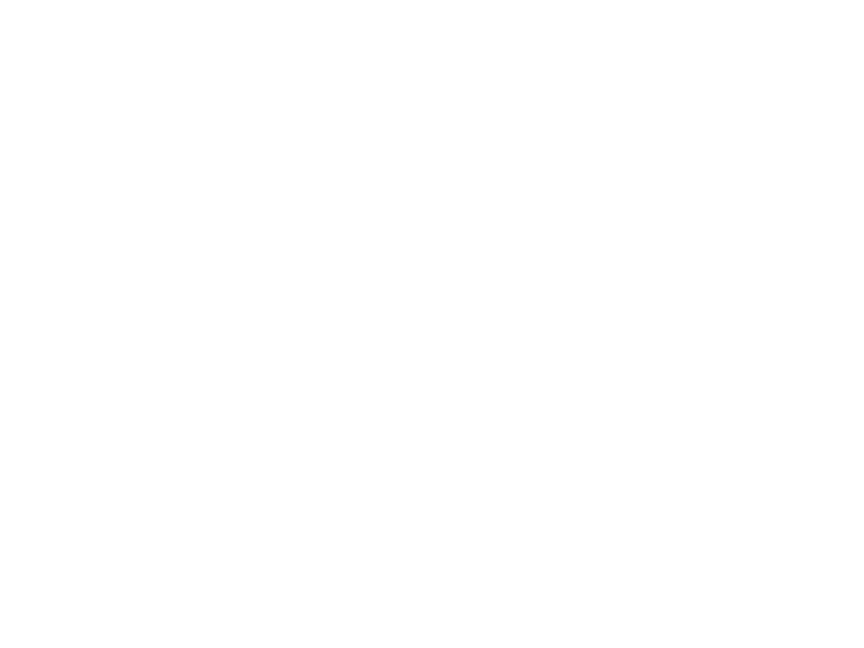

In [89]:
%matplotlib notebook
file_string = 'utility_universal_dt_{}_nf{}_e{}.pickle'.format(target, n_folds, n_experiments)
with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        fp_utility_results_DT = pickle.load(infile)
        
x_axis = [1.0/g for g in fp_utility_results_DT.keys()]
y_axis = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results_DT[gamma]]) for gamma in fp_utility_results_DT.keys()]
plt.plot(x_axis, y_axis, label='utility after fingerprint')
plt.title('Utility of fingerprinted data')
plt.xlabel('#marks rel data size')
plt.ylabel('Accuracy knn')
plt.show()

### 3.3 Gradient Boosting

In [90]:
#gammae = [1, 2, 3, 4, 6, 12, 25, 50, 100]
fp_utility_results_GB = {}
n_folds = 5
n_experiments = 10

file_string = 'utility_universal_gb_{}_nf{}_e{}.pickle'.format(target, n_folds, n_experiments)

# check if results exist
# ---------------------- #
if os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
            fp_utility_results_GB = pickle.load(infile)
    print('Results already exist for gammae: ' + str(fp_utility_results_GB.keys()))
gammae_new = []
for gamma in gammae:
    if gamma not in fp_utility_results_GB.keys():
        gammae_new.append(gamma)
# ---------------------- #        
# update results
for gamma in gammae_new:
    print('Updating results for gamma='+str(gamma))
    fp_utility_gb = fingerprint_utility_gb(Adult(), target, gamma, n_folds=n_folds, n_experiments=n_experiments) 
    # [cv_acc_1, cv_acc_2, ..., cv_acc_n_exp]
    fp_utility_results_GB[gamma] = fp_utility_gb
    
fp_utility_results_GB =  dict(sorted(fp_utility_results_GB.items()))
with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(fp_utility_results_GB, outfile)

Updating results for gamma=1
Updating results for gamma=2
Updating results for gamma=3
Updating results for gamma=4
Updating results for gamma=5
Updating results for gamma=6
Updating results for gamma=10
Updating results for gamma=12
Updating results for gamma=15
Updating results for gamma=18
Updating results for gamma=20
Updating results for gamma=25
Updating results for gamma=30
Updating results for gamma=50
Updating results for gamma=100
Updating results for gamma=200


<IPython.core.display.Javascript object>


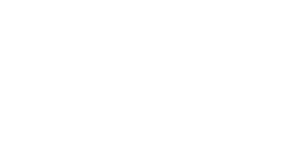

In [91]:
%matplotlib notebook
file_string = 'utility_universal_gb_{}_nf{}_e{}.pickle'.format(target, n_folds, n_experiments)
with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        fp_utility_results_GB = pickle.load(infile)
        
x_axis = [1.0/g for g in fp_utility_results_GB.keys()]
y_axis = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results_GB[gamma]]) for gamma in fp_utility_results_GB.keys()]
plt.plot(x_axis, y_axis, label='utility after fingerprint')
plt.title('Utility of fingerprinted data')
plt.xlabel('#marks rel data size')
plt.ylabel('Accuracy knn')
plt.show()

## COMBINED RESULTS

In [36]:
with open('parameter_guidelines/evaluation/adult/inverse_robustness_horizontal_universal_c95_ag05_e100.pickle', 'rb') as infile:
    resutls = pickle.load(infile)

In [37]:
# interceptions
x_intercept_0 = 1.0/(max([x for x in resutls if 1-resutls[x]>=att_utility_bounds[0]]))
x_intercept_1 = 1.0/(max([x for x in resutls if 1-resutls[x]>=att_utility_bounds[1]]))

<IPython.core.display.Javascript object>


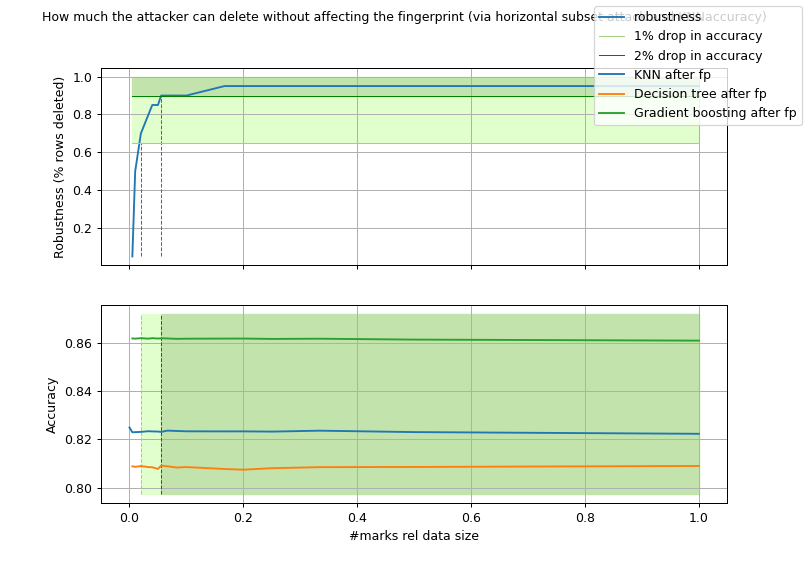

In [98]:
# incorporate in the full analysis
%matplotlib notebook
fig, ax = plt.subplots(2, sharex=True, figsize=(10, 7)) # sharey=True

lines = []
fill = []
helpers = []

x_axis = [1.0/g for g in gammae]

# ---------------------------- #
# robustness
# ---------------------------- #
y_robustness = [1 - inv_robustness for inv_robustness in resutls.values()]
lines.append(ax[0].plot(x_axis, y_robustness, label='robustness'))

# --------------------------- #
# utility (start)
# --------------------------- #
y_utility = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results[g]])
             for g in fp_utility_results.keys()] + [np.mean(original_utility_knn)]
y_utility_DT = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results_DT[g]])
                for g in fp_utility_results_DT.keys()]
y_utility_GB = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results_GB[g]])
                for g in fp_utility_results_GB.keys()]
y_utility_all = y_utility + y_utility_DT + y_utility_GB

# --------------------------- #
# attack utility
# --------------------------- #
lw = 0.8
bound_patch = 0.01

lines.append(ax[0].plot(x_axis, [att_utility_bounds[0] for x in resutls], label='1% drop in accuracy', linewidth=lw, 
                        color='#a2d180'))
fill.append(ax[0].fill_between(x_axis, [att_utility_bounds[0] for x in resutls], 1.0, color='#e1ffcc'))
helpers.append(ax[0].vlines(x=x_intercept_0, ymin=min(y_robustness), ymax=att_utility_bounds[0], linewidth=lw, 
                            linestyles='dashed'))
helpers.append(ax[1].vlines(x=x_intercept_0, ymin=min(y_utility_all)-bound_patch, ymax=max(y_utility_all)+bound_patch, 
                            linewidth=lw, linestyles='dashed', color='#a2d180'))
fill.append(ax[1].fill_between([x for x in x_axis if x>=x_intercept_0], min(y_utility_all)-bound_patch,
                               max(y_utility_all)+bound_patch, color='#e1ffcc'))

lines.append(ax[0].plot(x_axis, [att_utility_bounds[1] for x in resutls], label='2% drop in accuracy', linewidth=lw, 
                        color='green'))
fill.append(ax[0].fill_between(x_axis, [att_utility_bounds[1] for x in resutls], 1.0, color='#c3e3ac'))
helpers.append(ax[0].vlines(x=x_intercept_1, ymin=min(y_robustness), ymax=att_utility_bounds[1], linewidth=lw, 
                            linestyles='dashed'))
helpers.append(ax[1].vlines(x=x_intercept_1, ymin=min(y_utility_all)-bound_patch, ymax=max(y_utility_all)+bound_patch, 
                            linewidth=lw, linestyles='dashed', color='green'))
fill.append(ax[1].fill_between([x for x in x_axis if x>=x_intercept_1], min(y_utility_all)-bound_patch,
                               max(y_utility_all)+bound_patch, color='#c3e3ac'))

# todo: mark on the first subplot (ax[0]) when the utility gets way too low; eg. -1%, -2% etc

# ---------------------------- #
# utility
# ---------------------------- #
# KNN
y_utility = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results[g]]) 
                                    for g in fp_utility_results.keys()] + [np.mean(original_utility_knn)]
lines.append(ax[1].plot(x_axis+[0.0], y_utility, label='KNN after fp'))
# Decision Tree
lines.append(ax[1].plot(x_axis, y_utility_DT, label='Decision tree after fp'))
# Gradient Boosting
lines.append(ax[1].plot(x_axis, y_utility_GB, label='Gradient boosting after fp'))
ax[1].set_ylabel('Accuracy')
# ---------------------------- #

fig.suptitle('How much the attacker can delete without affecting the fingerprint (via horizontal subset attack and KNN' + 
             'accuracy)', size=10)
plt.xlabel('#marks rel data size') 
ax[0].set_ylabel('Robustness (% rows deleted)')

plt.rcParams['axes.grid'] = True

legend = fig.legend()
line_legends = legend.get_lines()
for line in line_legends:
    line.set_picker(True)
    line.set_pickradius(10)
graphs = {}
graphs[line_legends[0]] = [lines[0][0]] # -> robustness
graphs[line_legends[1]] = [lines[1][0], fill[0], helpers[0], fill[1], helpers[1]] # -> attack utility 
graphs[line_legends[2]] = [lines[2][0], fill[2], helpers[2], fill[3], helpers[3]]
graphs[line_legends[3]] = [lines[3][0]] # -> utility
graphs[line_legends[4]] = [lines[4][0]]
graphs[line_legends[5]] = [lines[5][0]]

   
def on_pick(event):
    legend = event.artist
    isVisible = legend.get_visible()
    for element in graphs[legend]:
        element.set_visible(not isVisible)
    legend.set_visible(not isVisible)
    fig.canvas.draw()
    
plt.connect('pick_event', on_pick)
plt.show()

Robustness plot (above):
- in the dark green area, the utility of the attacker's data is expected to drop at least 2% for the observed attacks, in addition to the increased robustness for that area. This helps determining the lower boundary on what is considered a robust scheme. Therefore, on the one hand, while choosing the number of marks (x axis), the user can say "if the attacker needs to modify at least 50% of data (i.e. robustness=50%), the scheme is robust", or on the other hand "if the attacker loses more than 2% of accuracy by modifying the data, the scheme is considered robust", or a combination of both. 
- the light green area represents where the utility is expected to drop at least 1% due to the attack strength

Utility plot (below):
- the dark and light green areas are transposed to help find the lower boundary of number of marks that the user wants to chose
- users wants to choose the #marks (x axis) with the highest accuracy
- the idea for the alternative plot regarding utility might be to plot relative delta accuracy (real_acc-original_acc)/original_acc -> for each classifier and cumulative